In [38]:
'''
==================================================================================================
AST Parser
==================================================================================================
This file contains the code to parse the AST of a given code snippet using tree-sitter.
==================================================================================================
Authors: 
  José Armando Rosas Balderas | A01704132
  Ramona Najera Fuentes       | A01423596
  Ian Joab Padron Corona      | A01708940
Date: 2025-Apr-28
==================================================================================================
Libraries

tree-stitter: Library for parsing source code into an AST.
sys: Library for system-specific parameters and functions.
==================================================================================================
'''
from tree_sitter import Language, Parser
import sys
import networkx as nx
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [39]:
def dfs_ast(node, level=0, node_list=None):
  """
  Perform a depth-first search (DFS) on the AST and store the nodes in a list. 
  Preorder traversal is used to visit the nodes.

  Parameters
  ---
  node: `Tree Sitter Node` The current node in the AST.

  level: `int` The current level in the tree. Default is 0.

  node_list: `list` The list to store the nodes. Default is None.

  Returns
  ---
  node_list: `list` The list of nodes in the AST.
  """
  
  if node_list is None:
      node_list = []
  
  node_list.append((node.type, level))

  # Recursively process child nodes
  for child in node.children:
      dfs_ast(child, level + 1, node_list)
  
  return node_list

In [40]:
def hierarchy_pos(G, root, width=1., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    """
    Position nodes in a hierarchy layout.
    
    Parameters
    ---
    G: `Graph` The graph to be laid out.
    
    root: `Node` The root node of the hierarchy.
    
    width: `float` The width of the layout.
    
    vert_gap: `float` The vertical gap between nodes.
    
    vert_loc: `float` The vertical location of the root node.
    
    xcenter: `float` The horizontal center of the layout.
    
    Returns
    ---
    pos: `dict` A dictionary mapping nodes to their positions in the layout.
    """
    def _hierarchy_pos(G, root, leftmost, width, vert_gap, vert_loc, xcenter, pos, parent=None):
        
        children = list(G.successors(root))
        
        if not children:
            pos[root] = (leftmost[0], vert_loc)
            leftmost[0] += width
        
        else:
            for child in children:
                pos = _hierarchy_pos(G, child, leftmost, width, vert_gap, vert_loc - vert_gap, xcenter, pos, root)
            mid = (pos[children[0]][0] + pos[children[-1]][0]) / 2
            pos[root] = (mid, vert_loc)
        
        return pos

    return _hierarchy_pos(G, root, [0], width, vert_gap, vert_loc, xcenter, {})

In [41]:
def build_graph_from_ts_node(graph, node, parent=None, counter=[0]):
    """
    Recursively build a graph from a Tree-sitter node

    Parameters
    ---
    
    graph: `Graph` The graph to be built.
    
    node: `Tree Sitter Node` The current node in the AST.
    
    parent: `Node` The parent node of the current node. Default is None.
    
    counter: `list` A list to keep track of the node index. Default is [0].
    
    Returns
    ---
    graph: `Graph` The graph built from the Tree-sitter node.
    """
    
    idx = counter[0]
    label = node.type
    
    if node.child_count == 0:
        label += f": {node.text.decode('utf8')}"
    graph.add_node(idx, label=label)

    if parent is not None:
        graph.add_edge(parent, idx)

    counter[0] += 1
    
    for child in node.children:
        build_graph_from_ts_node(graph, child, idx, counter)

    return graph

In [42]:
def printTreeNodes(nodes_list):
    """
    Print the nodes of the AST in a readable format with tabulations to represent the tree structure.

    Parameters
    ---
    nodes_list: `list` The list of nodes in the AST.
    """
    for node_type, level in nodes_list:
        print(f"{'· ' * level}{node_type}")

In [43]:
def main():
    # Define the constants for the Parser
    lang_grammar = 'java'
    path_grammar = '../domain/entities/grammars/java.so'
    file = '../../resources/datasets/original/java/HelloWorld.java'

    # Initialize the parser
    parser = Parser()

    if lang_grammar == 'cpp':
        try:
            parser.set_language(Language(path_grammar, 'cpp'))
        
        except Exception as e:
            print(f"[ERROR]: Failed to load C++ language grammar. {e}")
            sys.exit(1)

    elif lang_grammar == 'java':
        try:
            parser.set_language(Language(path_grammar, 'java'))
        
        except Exception as e:
            print(f"[ERROR]: Failed to load Java language grammar. {e}")
            sys.exit(1)

    else:
        print("[ARG0]: Language not supported. Please use 'cpp' or 'java'.")
        sys.exit(1)


    # Read codes from the provided file path
    with open(file, 'rb') as f:
        code = f.read()

    # Generate the AST for the provided code snippets
    tree = parser.parse(code)

    # Generate the list of nodes using DFS
    ast_nodes = dfs_ast(tree.root_node)

    # Output.txt
    printTreeNodes(ast_nodes)
    
    # Build a graph from the AST
    root_node = tree.root_node
    G = build_graph_from_ts_node(nx.DiGraph(), root_node)

    # Labels
    labels = {n: d['label'] for n, d in G.nodes(data=True)}

    # Draw the graph
    pos = hierarchy_pos(G, root=0)
    plt.figure(figsize=(20, 8))
    nx.draw(G, pos, labels=labels, node_color='lightblue', node_size=2000, font_size=8, arrows=False)
    plt.title("Tree-sitter AST")
    plt.show()

program
· class_declaration
· · modifiers
· · · public
· · class
· · identifier
· · class_body
· · · {
· · · method_declaration
· · · · modifiers
· · · · · public
· · · · · static
· · · · void_type
· · · · identifier
· · · · formal_parameters
· · · · · (
· · · · · formal_parameter
· · · · · · array_type
· · · · · · · type_identifier
· · · · · · · dimensions
· · · · · · · · [
· · · · · · · · ]
· · · · · · identifier
· · · · · )
· · · · block
· · · · · {
· · · · · expression_statement
· · · · · · method_invocation
· · · · · · · field_access
· · · · · · · · identifier
· · · · · · · · .
· · · · · · · · identifier
· · · · · · · .
· · · · · · · identifier
· · · · · · · argument_list
· · · · · · · · (
· · · · · · · · string_literal
· · · · · · · · · "
· · · · · · · · · string_fragment
· · · · · · · · · "
· · · · · · · · )
· · · · · · ;
· · · · · expression_statement
· · · · · · method_invocation
· · · · · · · field_access
· · · · · · · · identifier
· · · · · · · · .
· · · · · · · · identifier

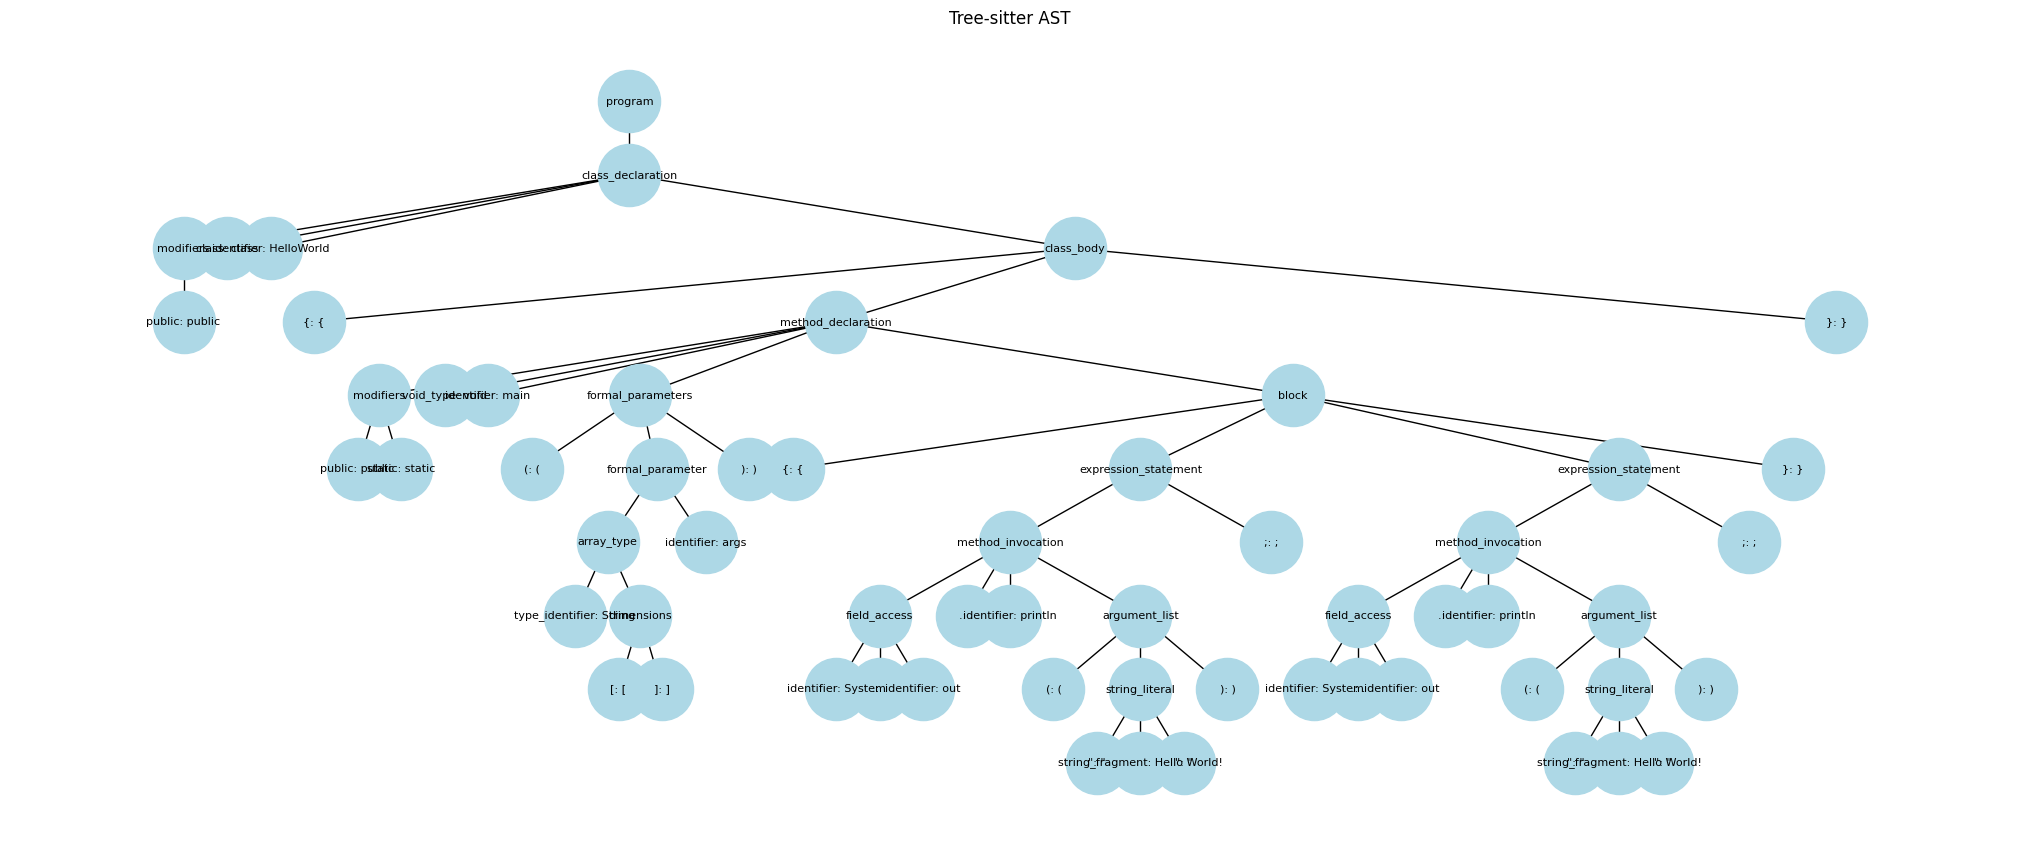

In [44]:
main()